In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import preprocessing
from sklearn.preprocessing import Normalizer,MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, ward
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_samples
from matplotlib import cm
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install openpyxl

In [3]:
data = pd.read_excel('innercity.xlsx')
data

,cid,dayhours,price,room_bed,room_bath,living_measure,lot_measure,ceil,coast,sight,...,basement,yr_built,yr_renovated,zipcode,lat,long,living_measure15,lot_measure15,furnished,total_area
0,3876100940,20150427T000000,600000,4.0,1.75,3050.0,9440.0,1,0,0.0,...,1250.0,1966,0,98034,47.7228,-122.183,2020.0,8660.0,0.0,12490
1,3145600250,20150317T000000,190000,2.0,1.00,670.0,3101.0,1,0,0.0,...,0.0,1948,0,98118,47.5546,-122.274,1660.0,4100.0,0.0,3771
2,7129303070,20140820T000000,735000,4.0,2.75,3040.0,2415.0,2,1,4.0,...,0.0,1966,0,98118,47.5188,-122.256,2620.0,2433.0,0.0,5455
3,7338220280,20141010T000000,257000,3.0,2.50,1740.0,3721.0,2,0,0.0,...,0.0,2009,0,98002,47.3363,-122.213,2030.0,3794.0,0.0,5461
4,7950300670,20150218T000000,450000,2.0,1.00,1120.0,4590.0,1,0,0.0,...,0.0,1924,0,98118,47.5663,-122.285,1120.0,5100.0,0.0,5710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,203600600,20150310T000000,685530,4.0,2.50,3130.0,60467.0,2,0,0.0,...,0.0,1996,0,98014,47.6618,-121.962,2780.0,44224.0,1.0,63597
21609,625049281,20140521T000000,535000,2.0,1.00,1030.0,4841.0,1,0,0.0,...,110.0,1939,0,98103,47.6860,-122.341,1530.0,4944.0,0.0,5871
21610,424069018,20140905T000000,998000,3.0,3.75,3710.0,34412.0,2,0,0.0,...,800.0,1978,0,98075,47.5888,-122.04,2390.0,34412.0,1.0,38122
21611,7258200055,20150206T000000,262000,4.0,2.50,1560.0,7800.0,2,0,0.0,...,0.0,1997,0,98168,47.5140,-122.316,1160.0,7800.0,0.0,9360


In [4]:
data_columns = data.columns
data_columns

Index(['cid', 'dayhours', 'price', 'room_bed', 'room_bath', 'living_measure',
       'lot_measure', 'ceil', 'coast', 'sight', 'condition', 'quality',
       'ceil_measure', 'basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'living_measure15', 'lot_measure15', 'furnished',
       'total_area'],
      dtype='object')

In [5]:
%%time
start='\033[1m'
end='\033[0;0m'

Wall time: 0 ns


In [6]:
print(start+'DATASET SUMMARY:'+end,'\n')
print(data.info(),'\n')

DATASET SUMMARY: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cid               21613 non-null  int64  
 1   dayhours          21613 non-null  object 
 2   price             21613 non-null  int64  
 3   room_bed          21505 non-null  float64
 4   room_bath         21505 non-null  float64
 5   living_measure    21596 non-null  float64
 6   lot_measure       21571 non-null  float64
 7   ceil              21571 non-null  object 
 8   coast             21612 non-null  object 
 9   sight             21556 non-null  float64
 10  condition         21556 non-null  object 
 11  quality           21612 non-null  float64
 12  ceil_measure      21612 non-null  float64
 13  basement          21612 non-null  float64
 14  yr_built          21612 non-null  object 
 15  yr_renovated      21613 non-null  int64  
 16  zipcode           216

#  Variable transformation

In [12]:
data.coast.value_counts()

0    21421
1      161
$       30
Name: coast, dtype: int64

In [16]:
# columns where the $ characater is found
data.select_dtypes([np.object]).apply(lambda x: x.str.contains('$').any())

dayhours      True
ceil          True
coast         True
condition     True
yr_built      True
long          True
total_area    True
dtype: bool

In [21]:
test = data.select_dtypes([np.object]).apply(lambda x: x.str.contains('$').any())
character_list =test.index.values.tolist()
character_list

['dayhours', 'ceil', 'coast', 'condition', 'yr_built', 'long', 'total_area']

In [26]:
#function replacing character value
def replace_char_in_column(df, column_name, char_to_replace, replacement_char):
    df[column_name] = df[column_name].apply(lambda x: x.replace(char_to_replace, replacement_char))
    return df

In [28]:
replace_char_in_column(data, character_list, "$", np.nan)

,cid,dayhours,price,room_bed,room_bath,living_measure,lot_measure,ceil,coast,sight,...,basement,yr_built,yr_renovated,zipcode,lat,long,living_measure15,lot_measure15,furnished,total_area
0,3876100940,20150427T000000,600000,4.0,1.75,3050.0,9440.0,1.0,0.0,0.0,...,1250.0,1966.0,0,98034,47.7228,-122.183,2020.0,8660.0,0.0,12490.0
1,3145600250,20150317T000000,190000,2.0,1.00,670.0,3101.0,1.0,0.0,0.0,...,0.0,1948.0,0,98118,47.5546,-122.274,1660.0,4100.0,0.0,3771.0
2,7129303070,20140820T000000,735000,4.0,2.75,3040.0,2415.0,2.0,1.0,4.0,...,0.0,1966.0,0,98118,47.5188,-122.256,2620.0,2433.0,0.0,5455.0
3,7338220280,20141010T000000,257000,3.0,2.50,1740.0,3721.0,2.0,0.0,0.0,...,0.0,2009.0,0,98002,47.3363,-122.213,2030.0,3794.0,0.0,5461.0
4,7950300670,20150218T000000,450000,2.0,1.00,1120.0,4590.0,1.0,0.0,0.0,...,0.0,1924.0,0,98118,47.5663,-122.285,1120.0,5100.0,0.0,5710.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,203600600,20150310T000000,685530,4.0,2.50,3130.0,60467.0,2.0,0.0,0.0,...,0.0,1996.0,0,98014,47.6618,-121.962,2780.0,44224.0,1.0,63597.0
21609,625049281,20140521T000000,535000,2.0,1.00,1030.0,4841.0,1.0,0.0,0.0,...,110.0,1939.0,0,98103,47.6860,-122.341,1530.0,4944.0,0.0,5871.0
21610,424069018,20140905T000000,998000,3.0,3.75,3710.0,34412.0,2.0,0.0,0.0,...,800.0,1978.0,0,98075,47.5888,-122.040,2390.0,34412.0,1.0,38122.0
21611,7258200055,20150206T000000,262000,4.0,2.50,1560.0,7800.0,2.0,0.0,0.0,...,0.0,1997.0,0,98168,47.5140,-122.316,1160.0,7800.0,0.0,9360.0


In [29]:
data.coast.value_counts()

0.0    21421
1.0      161
Name: coast, dtype: int64

In [30]:
data.select_dtypes([np.object]).apply(lambda x: x.str.contains('$').any())

dayhours    True
dtype: bool

In [36]:
data.dayhours.str.contains("$").count()

21613

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cid               21613 non-null  int64  
 1   dayhours          21613 non-null  object 
 2   price             21613 non-null  int64  
 3   room_bed          21505 non-null  float64
 4   room_bath         21505 non-null  float64
 5   living_measure    21596 non-null  float64
 6   lot_measure       21571 non-null  float64
 7   ceil              21541 non-null  float64
 8   coast             21582 non-null  float64
 9   sight             21556 non-null  float64
 10  condition         21528 non-null  float64
 11  quality           21612 non-null  float64
 12  ceil_measure      21612 non-null  float64
 13  basement          21612 non-null  float64
 14  yr_built          21598 non-null  float64
 15  yr_renovated      21613 non-null  int64  
 16  zipcode           21613 non-null  int64 

In [38]:
data['condition']=data['condition'].astype('int', errors='ignore')
data['yr_built']=data['yr_built'].astype('int',errors='ignore')

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cid               21613 non-null  int64  
 1   dayhours          21613 non-null  object 
 2   price             21613 non-null  int64  
 3   room_bed          21505 non-null  float64
 4   room_bath         21505 non-null  float64
 5   living_measure    21596 non-null  float64
 6   lot_measure       21571 non-null  float64
 7   ceil              21541 non-null  float64
 8   coast             21582 non-null  float64
 9   sight             21556 non-null  float64
 10  condition         21528 non-null  float64
 11  quality           21612 non-null  float64
 12  ceil_measure      21612 non-null  float64
 13  basement          21612 non-null  float64
 14  yr_built          21598 non-null  float64
 15  yr_renovated      21613 non-null  int64  
 16  zipcode           21613 non-null  int64 

In [40]:
print(start+'Checking for Null values in the dataframe:'+end,'\n',data.isnull().sum(),'\n')

Checking for Null values in the dataframe: 
 cid                   0
dayhours              0
price                 0
room_bed            108
room_bath           108
living_measure       17
lot_measure          42
ceil                 72
coast                31
sight                57
condition            85
quality               1
ceil_measure          1
basement              1
yr_built             15
yr_renovated          0
zipcode               0
lat                   0
long                 34
living_measure15    166
lot_measure15        29
furnished            29
total_area           68
dtype: int64 



# Dealing with missing values using simple imputer

In [54]:
#function Filling the missing values in categorical variable using Mode
from typing import List

def fill_nan_with_mode(df, column_names:List):
    for column in column_names:
        mode = df[column].mode().values[0]
        df[column].fillna(mode, inplace=True)
    return df

In [56]:
# filling nan for categorical data with mode
categorical_columns = ['furnished','quality', 'condition', 'coast', 'ceil', 'sight', 'yr_renovated']

fill_nan_with_mode(data, categorical_columns)
print(start+'Checking for Null values in the dataframe:'+end,'\n',data.isnull().sum(),'\n')

Checking for Null values in the dataframe: 
 cid                   0
dayhours              0
price                 0
room_bed            108
room_bath           108
living_measure       17
lot_measure          42
ceil                  0
coast                 0
sight                 0
condition             0
quality               0
ceil_measure          1
basement              1
yr_built             15
yr_renovated          0
zipcode               0
lat                   0
long                 34
living_measure15    166
lot_measure15        29
furnished             0
total_area           68
dtype: int64 



In [58]:
# Filling the missing value in numerical variables using Median
def fill_nan_with_median(df, column_names:List):
    for column in column_names:
        median = df[column].median()
        df[column].fillna(median, inplace=True)
    return df

In [67]:
# create a list of numerical columns
numerical_columns = data.drop(categorical_columns,axis=1).columns.tolist()  

# remove additional columns
[numerical_columns.remove(elem) for elem in ['cid', 'dayhours']]

numerical_columns

['price',
 'room_bed',
 'room_bath',
 'living_measure',
 'lot_measure',
 'ceil_measure',
 'basement',
 'yr_built',
 'zipcode',
 'lat',
 'long',
 'living_measure15',
 'lot_measure15',
 'total_area']

In [57]:
data.median()

cid                 3.904930e+09
price               4.500000e+05
room_bed            3.000000e+00
room_bath           2.250000e+00
living_measure      1.910000e+03
lot_measure         7.618000e+03
ceil                1.500000e+00
coast               0.000000e+00
sight               0.000000e+00
condition           3.000000e+00
quality             7.000000e+00
ceil_measure        1.560000e+03
basement            0.000000e+00
yr_built            1.975000e+03
yr_renovated        0.000000e+00
zipcode             9.806500e+04
lat                 4.757180e+01
long               -1.222300e+02
living_measure15    1.840000e+03
lot_measure15       7.620000e+03
furnished           0.000000e+00
total_area          9.575000e+03
dtype: float64

In [69]:
fill_nan_with_median(data, numerical_columns)

,cid,dayhours,price,room_bed,room_bath,living_measure,lot_measure,ceil,coast,sight,...,basement,yr_built,yr_renovated,zipcode,lat,long,living_measure15,lot_measure15,furnished,total_area
0,3876100940,20150427T000000,600000,4.0,1.75,3050.0,9440.0,1.0,0.0,0.0,...,1250.0,1966.0,0,98034,47.7228,-122.183,2020.0,8660.0,0.0,12490.0
1,3145600250,20150317T000000,190000,2.0,1.00,670.0,3101.0,1.0,0.0,0.0,...,0.0,1948.0,0,98118,47.5546,-122.274,1660.0,4100.0,0.0,3771.0
2,7129303070,20140820T000000,735000,4.0,2.75,3040.0,2415.0,2.0,1.0,4.0,...,0.0,1966.0,0,98118,47.5188,-122.256,2620.0,2433.0,0.0,5455.0
3,7338220280,20141010T000000,257000,3.0,2.50,1740.0,3721.0,2.0,0.0,0.0,...,0.0,2009.0,0,98002,47.3363,-122.213,2030.0,3794.0,0.0,5461.0
4,7950300670,20150218T000000,450000,2.0,1.00,1120.0,4590.0,1.0,0.0,0.0,...,0.0,1924.0,0,98118,47.5663,-122.285,1120.0,5100.0,0.0,5710.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,203600600,20150310T000000,685530,4.0,2.50,3130.0,60467.0,2.0,0.0,0.0,...,0.0,1996.0,0,98014,47.6618,-121.962,2780.0,44224.0,1.0,63597.0
21609,625049281,20140521T000000,535000,2.0,1.00,1030.0,4841.0,1.0,0.0,0.0,...,110.0,1939.0,0,98103,47.6860,-122.341,1530.0,4944.0,0.0,5871.0
21610,424069018,20140905T000000,998000,3.0,3.75,3710.0,34412.0,2.0,0.0,0.0,...,800.0,1978.0,0,98075,47.5888,-122.040,2390.0,34412.0,1.0,38122.0
21611,7258200055,20150206T000000,262000,4.0,2.50,1560.0,7800.0,2.0,0.0,0.0,...,0.0,1997.0,0,98168,47.5140,-122.316,1160.0,7800.0,0.0,9360.0


In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cid               21613 non-null  int64  
 1   dayhours          21613 non-null  object 
 2   price             21613 non-null  int64  
 3   room_bed          21613 non-null  float64
 4   room_bath         21613 non-null  float64
 5   living_measure    21613 non-null  float64
 6   lot_measure       21613 non-null  float64
 7   ceil              21613 non-null  float64
 8   coast             21613 non-null  float64
 9   sight             21613 non-null  float64
 10  condition         21613 non-null  float64
 11  quality           21613 non-null  float64
 12  ceil_measure      21613 non-null  float64
 13  basement          21613 non-null  float64
 14  yr_built          21613 non-null  float64
 15  yr_renovated      21613 non-null  int64  
 16  zipcode           21613 non-null  int64 

# ANOTHER APPROACH

In [ ]:
# from sklearn.impute import SimpleImputer
# my_imputer = SimpleImputer(strategy = 'median')
# data_new = my_imputer.fit_transform(data.drop(['dayhours'],axis=1))

In [ ]:
# data.drop(['dayhours','furnished','quality', 'condition', 'coast', 'ceil', 'sight', 'yr_renovated'],axis=1).columns.values

In [ ]:
# df= pd.DataFrame(data_new,columns=data.drop(['dayhours'],axis=1).columns)
# df['dayhours']=data['dayhours']
# df

In [71]:
df = data.copy()

# Looking into the values in each column

In [72]:
#function for getting insigt for each column values
def values_in_columns(df):
    for i in df.columns:
        print(start+'Column Name--->'+i+end)
        print('Number of Unique Values',df[i].nunique(),'\n')
        print('Count of each unique value \n',df[i].value_counts(),'\n')

In [73]:
values_in_columns(df)

Column Name--->cid
Number of Unique Values 21436 

Count of each unique value 
 795000620     3
5101405604    2
9809000020    2
7853420110    2
6021500970    2
             ..
7871500485    1
2022069200    1
9808630120    1
7302000210    1
8805900430    1
Name: cid, Length: 21436, dtype: int64 

Column Name--->dayhours
Number of Unique Values 372 

Count of each unique value 
 20140623T000000    142
20140625T000000    131
20140626T000000    131
20140708T000000    127
20150427T000000    126
                  ... 
20150515T000000      1
20150110T000000      1
20140803T000000      1
20150131T000000      1
20140830T000000      1
Name: dayhours, Length: 372, dtype: int64 

Column Name--->price
Number of Unique Values 3625 

Count of each unique value 
 450000    172
350000    172
550000    159
500000    152
425000    150
         ... 
919000      1
364988      1
362764      1
849900      1
685530      1
Name: price, Length: 3625, dtype: int64 

Column Name--->room_bed
Number of Unique Value

In [77]:
#!pip install pandas-profiling

In [80]:
import pandas_profiling as pp
report = pp.ProfileReport(df)
report.to_file('profile_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Dropping the dupplicates values

In [88]:
# function for dropping duplicates        
def duplicate(df):
    if df.duplicated().sum()>0:
        print(start+'Dataframe contains duplicate values'+end,df.duplicated().sum())
        df.drop_duplicates(inplace=True,ignore_index=True)
        print('Details of dataframe after droping the Duplicate rows')
        details(df)
    else:
        print("Dataframe doesn't contains duplicate Values")

In [89]:
duplicate(df)

Dataframe doesn't contains duplicate Values


In [90]:
# Data Analysis

df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cid,21613.0,4.580302e+09,2.876566e+09,1.000102e+06,2.123049e+09,3.904930e+09,7.308900e+09,9.900000e+09
price,21613.0,5.401822e+05,3.673622e+05,7.500000e+04,3.219500e+05,4.500000e+05,6.450000e+05,7.700000e+06
room_bed,21613.0,3.369500e+00,9.283307e-01,0.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.300000e+01
room_bath,21613.0,2.115845e+00,7.683799e-01,0.000000e+00,1.750000e+00,2.250000e+00,2.500000e+00,8.000000e+00
living_measure,21613.0,2.079727e+03,9.181472e+02,2.900000e+02,1.430000e+03,1.910000e+03,2.550000e+03,1.354000e+04
lot_measure,21613.0,1.509003e+04,4.138466e+04,5.200000e+02,5.043000e+03,7.618000e+03,1.066000e+04,1.651359e+06
ceil,21613.0,1.492481e+00,5.397630e-01,1.000000e+00,1.000000e+00,1.500000e+00,2.000000e+00,3.500000e+00
coast,21613.0,7.449220e-03,8.598879e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
sight,21613.0,2.337482e-01,7.655206e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
condition,21613.0,3.407718e+00,6.499332e-01,1.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00


</ol>
    <li><b>CID:</b> House ID/Property ID.Not used for analysis</li>
    <li><b>Dayhours:</b> 5 factor analysis is reflecting for this column</li>
    <li><b>price:</b> Our taget column value is in 75k - 7700k range. As Mean > Median, it's <b>rightly skewed</b>.</li>
    <li><b>room_bed:</b> Number of bedrooms range from 0 - 33. As Mean slightly > Median, it's <b>slightly rightly skewed.</b></li>
    <li><b>room_bath:</b> Number of bathrooms range from 0 - 8. As Mean slightly &lt; Median, it's <b>slightly leftly skewed</b>.</li>
    <li><b>living_measure:</b> Square footage of house range from 290 - 13,540. As Mean > Median, it's <b>rightly skewed</b>.</li>
    <li><b>lot_measure:</b> Square footage of lot range from 520 - 16,51,359. As Mean almost double of Median, it's <b>Hightly rightly skewed</b>.</li>
    <li><b>ceil:</b> Number of floors range from 1 - 3.5 As Mean ~ Median, it's <b>almost Normal Distributed</b>.</li>
    <li><b>coast:</b> As this value represent whether house has waterfront view or not. It's <b>categorical column</b>. From above analysis we got know, very few houses has waterfront view.</li>
    <li><b>sight:</b> Value ranges from 0 - 4. As Mean > Median, it's <b>rightly skewed</b></li>
    <li><b>condition:</b> Represents rating of house which ranges from 1 - 5. As Mean > Median, it's <b>rightly skewed</b></li>
    <li><b>quality:</b> Representign grade given to house which range from 1 - 13. As Mean > Median, it's <b>rightly skewed</b>.</li>
    <li><b>ceil_measure:</b> Square footage of house apart from basement ranges in 290 - 9,410. As Mean > Median, it's <b>rightly skewed</b>.</li>
    <li><b>basement:</b> Square footage house basement ranges in 0 - 4,820. As Mean highlty > Median, it's <b>Highly rightly skewed</b>.</li>
    <li><b>yr_built:</b> House built year ranges from 1900 - 2015. As Mean &lt; Median, it's <b>leftly skewed</b>.</li>
    <li><b>yr_renovated:</b> House renovation year only 2015. So this column can be used as <b>Categorical Variable</b> for knowing whether house is renovated or not.</li>
    <li><b>zipcode:</b> House ZipCode ranges from 98001 - 98199. As Mean > Median, it's <b>rightly skewed</b>.</li>
    <li><b>lat:</b> Lattitude ranges from 47.1559 - 47.7776 As Mean &lt; Median, it's <b>leftly skewed</b>.</li>
    <li><b>long:</b> Longittude ranges from -122.5190 to -121.315 As Mean > Median, it's <b>rightly skewed</b>.</li>
    <li><b>living_measure15:</b> Value ragnes from 399 to 6,210. As Mean > Median, it's <b>rightly skewed</b>.</li>
    <li><b>lot_measure15:</b> Value ragnes from 651 to 8,71,200. As Mean highly > Median, it's <b>Highly rightly skewed</b>.</li>
    <li><b>furnished:</b> Representing whether house is furnished or not. It's a <b>Categorical Variable</b></li>
    <li><b>total_area</b> Total area of house ranges from 1,423 to 16,52,659. As Mean is almost double of Median, it's <b>Highly rightly skewed</b></li>
</ol>


### Univariate Analysis 

In [93]:
df

,cid,dayhours,price,room_bed,room_bath,living_measure,lot_measure,ceil,coast,sight,...,basement,yr_built,yr_renovated,zipcode,lat,long,living_measure15,lot_measure15,furnished,total_area
0,3876100940,20150427T000000,600000,4.0,1.75,3050.0,9440.0,1.0,0.0,0.0,...,1250.0,1966.0,0,98034,47.7228,-122.183,2020.0,8660.0,0.0,12490.0
1,3145600250,20150317T000000,190000,2.0,1.00,670.0,3101.0,1.0,0.0,0.0,...,0.0,1948.0,0,98118,47.5546,-122.274,1660.0,4100.0,0.0,3771.0
2,7129303070,20140820T000000,735000,4.0,2.75,3040.0,2415.0,2.0,1.0,4.0,...,0.0,1966.0,0,98118,47.5188,-122.256,2620.0,2433.0,0.0,5455.0
3,7338220280,20141010T000000,257000,3.0,2.50,1740.0,3721.0,2.0,0.0,0.0,...,0.0,2009.0,0,98002,47.3363,-122.213,2030.0,3794.0,0.0,5461.0
4,7950300670,20150218T000000,450000,2.0,1.00,1120.0,4590.0,1.0,0.0,0.0,...,0.0,1924.0,0,98118,47.5663,-122.285,1120.0,5100.0,0.0,5710.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,203600600,20150310T000000,685530,4.0,2.50,3130.0,60467.0,2.0,0.0,0.0,...,0.0,1996.0,0,98014,47.6618,-121.962,2780.0,44224.0,1.0,63597.0
21609,625049281,20140521T000000,535000,2.0,1.00,1030.0,4841.0,1.0,0.0,0.0,...,110.0,1939.0,0,98103,47.6860,-122.341,1530.0,4944.0,0.0,5871.0
21610,424069018,20140905T000000,998000,3.0,3.75,3710.0,34412.0,2.0,0.0,0.0,...,800.0,1978.0,0,98075,47.5888,-122.040,2390.0,34412.0,1.0,38122.0
21611,7258200055,20150206T000000,262000,4.0,2.50,1560.0,7800.0,2.0,0.0,0.0,...,0.0,1997.0,0,98168,47.5140,-122.316,1160.0,7800.0,0.0,9360.0


<Figure size 2000x800 with 0 Axes>

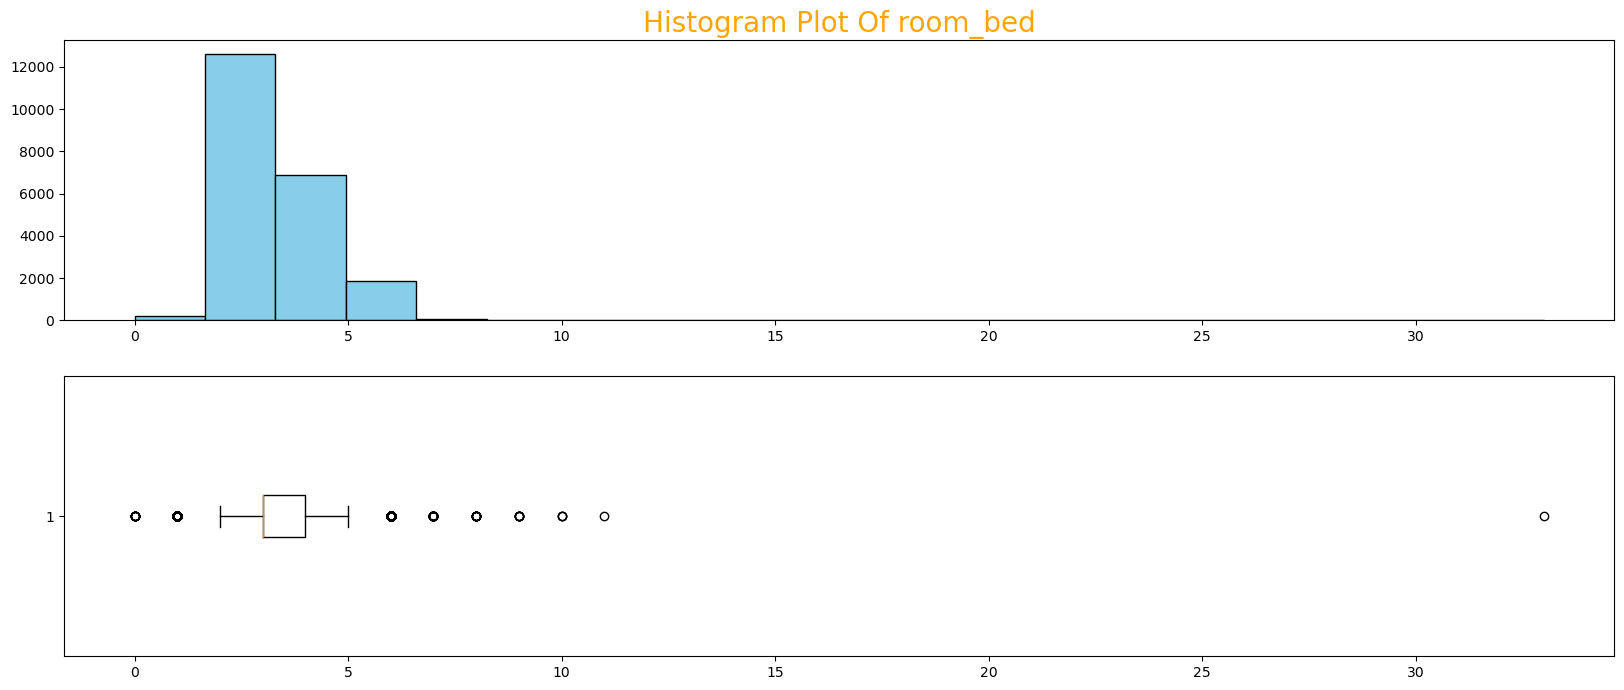

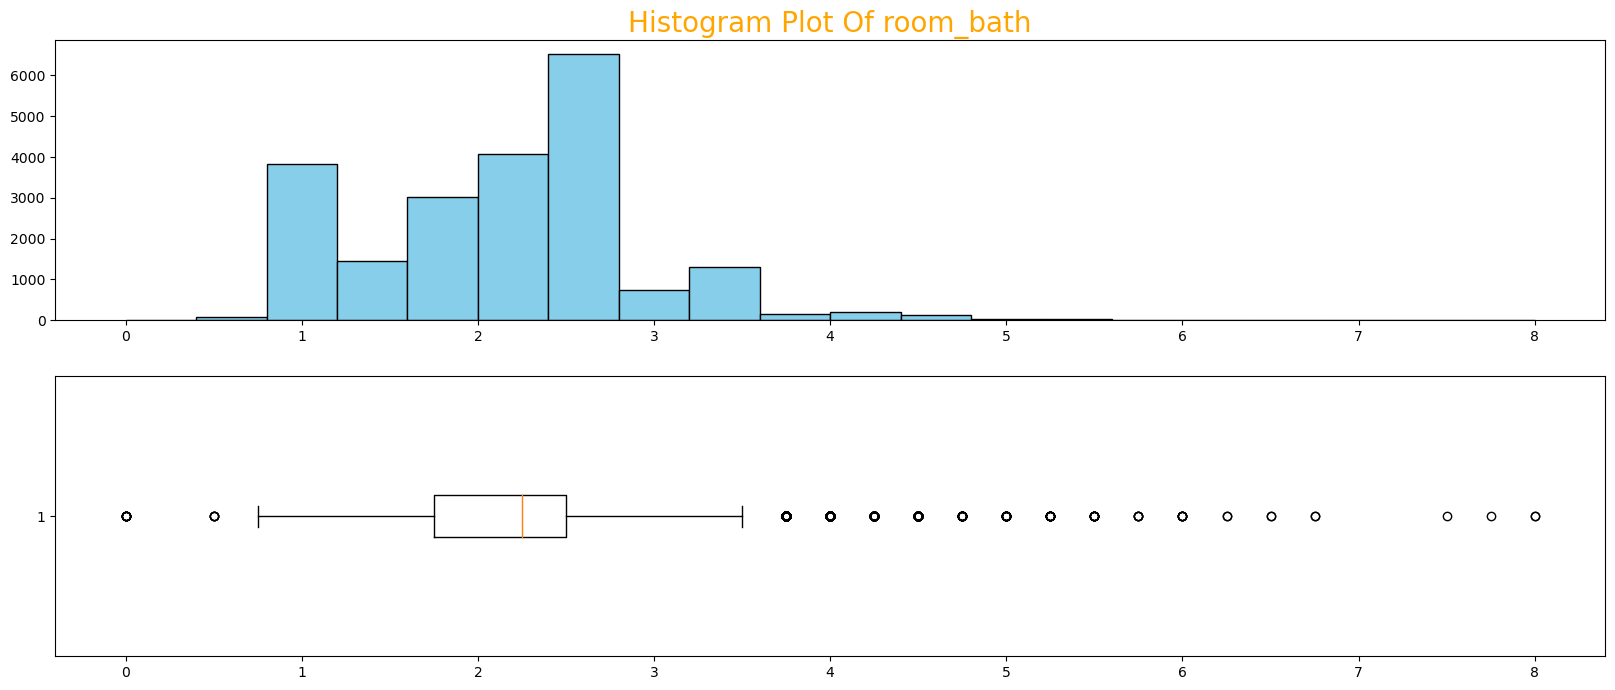

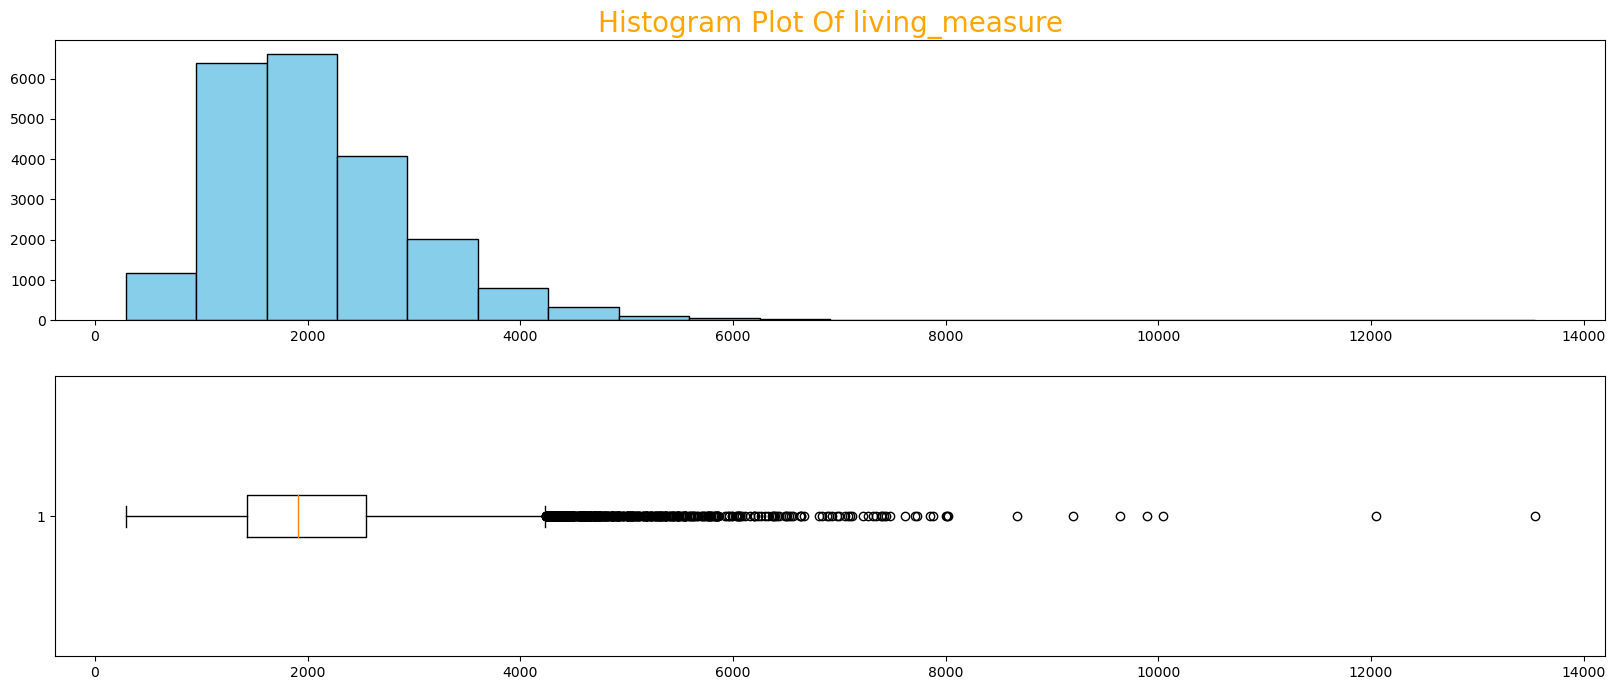

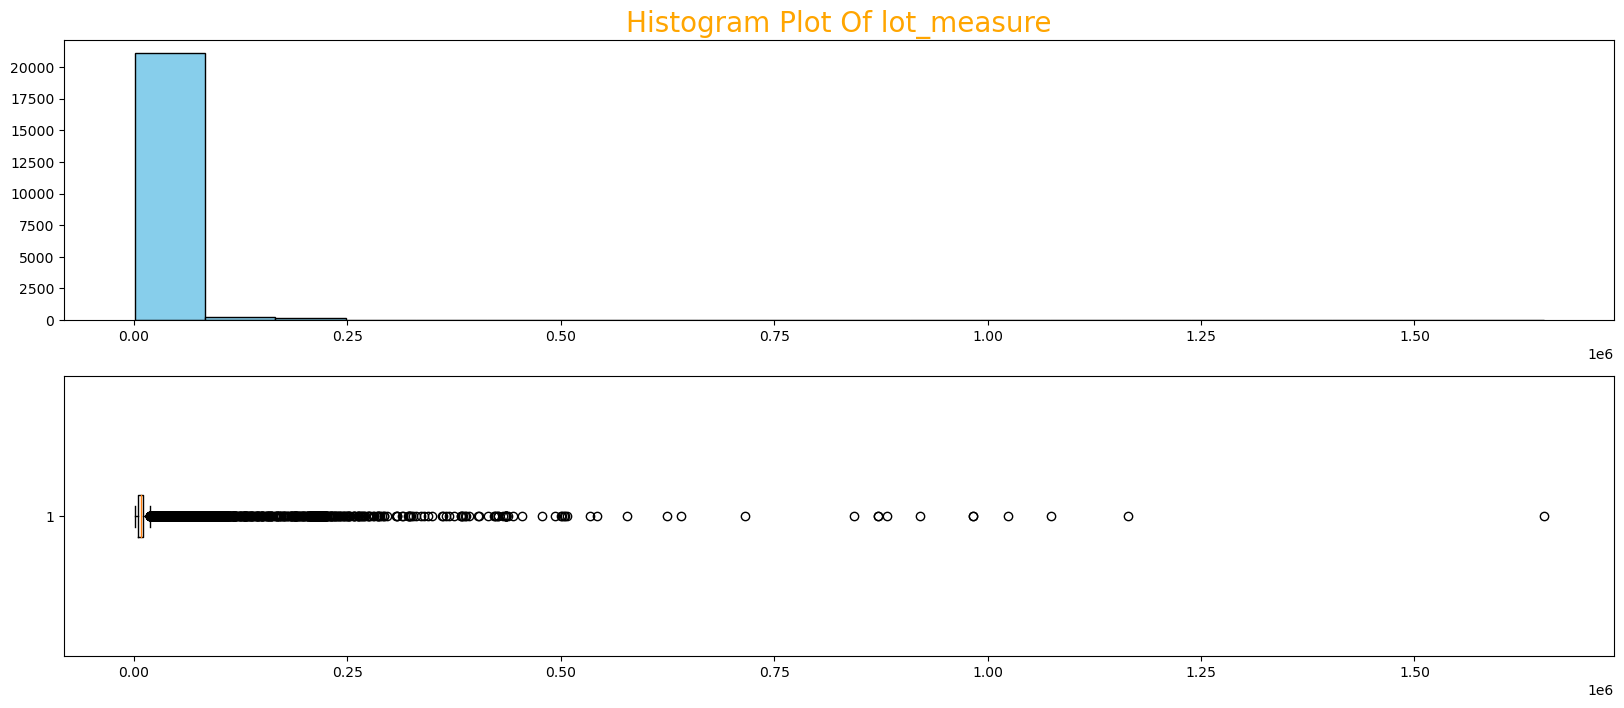

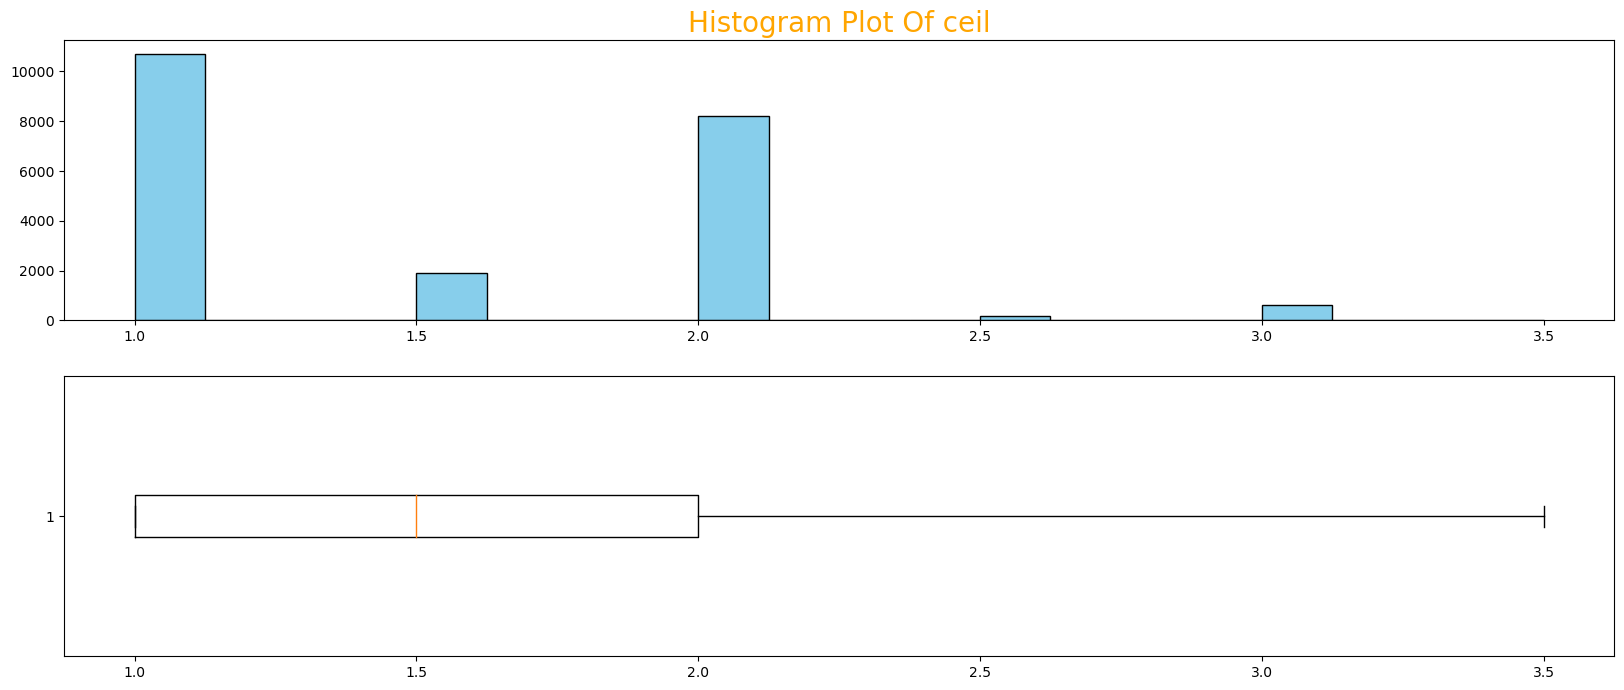

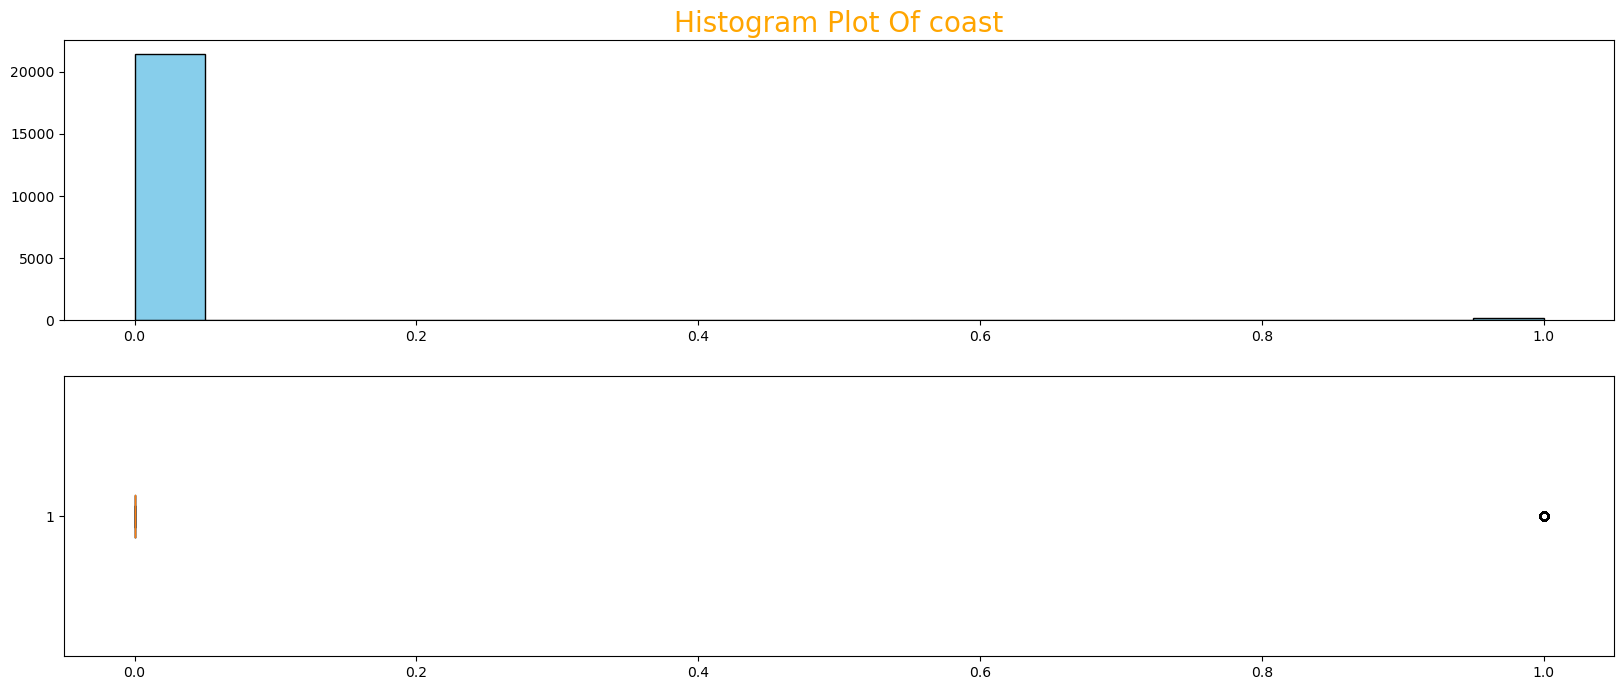

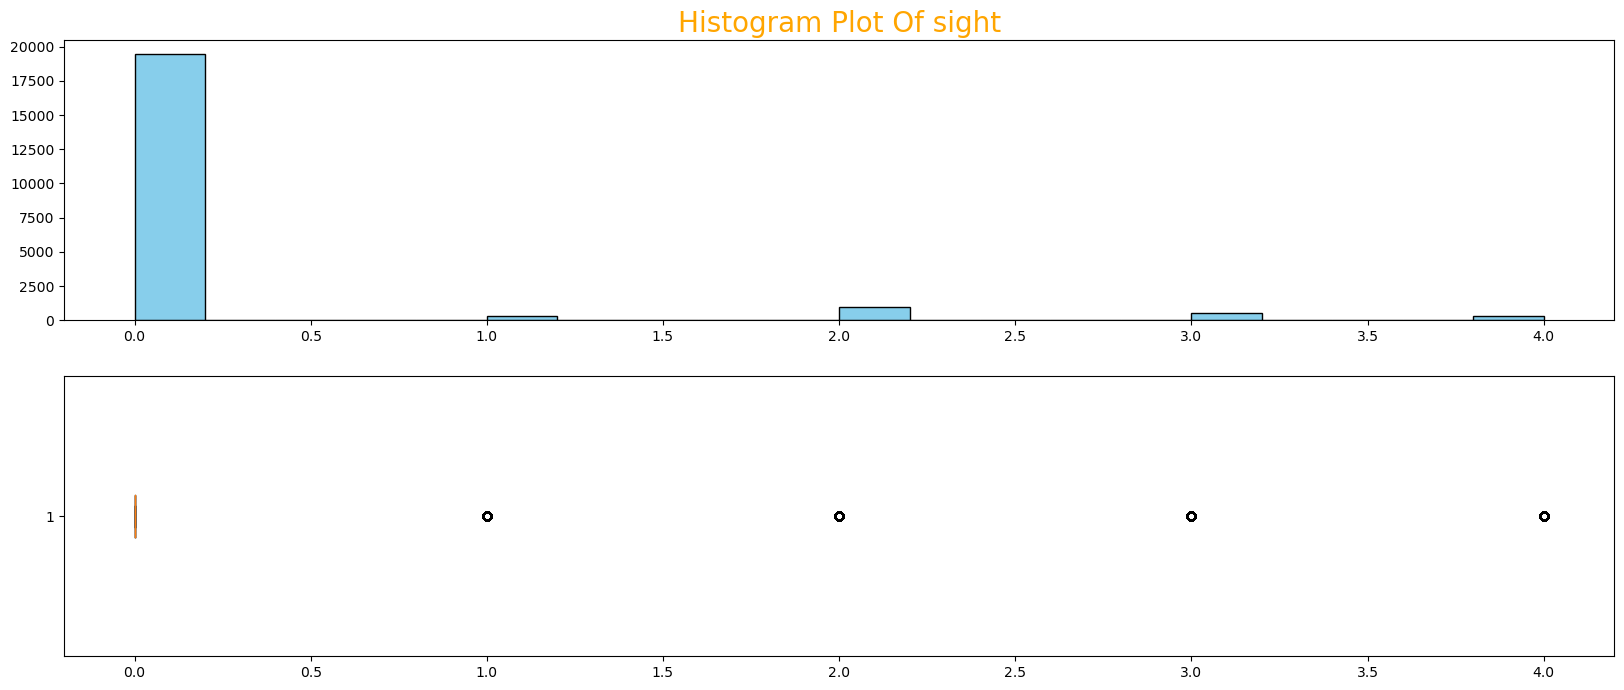

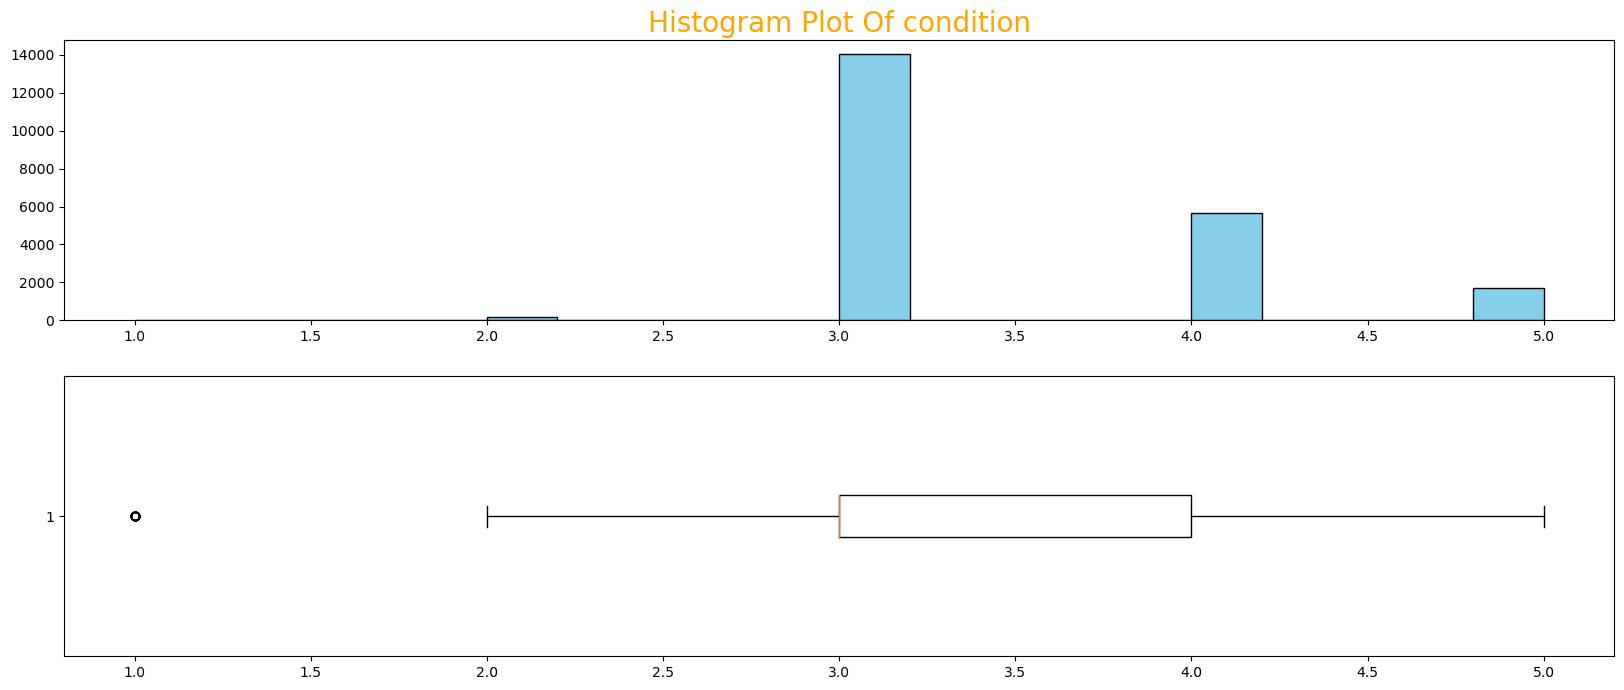

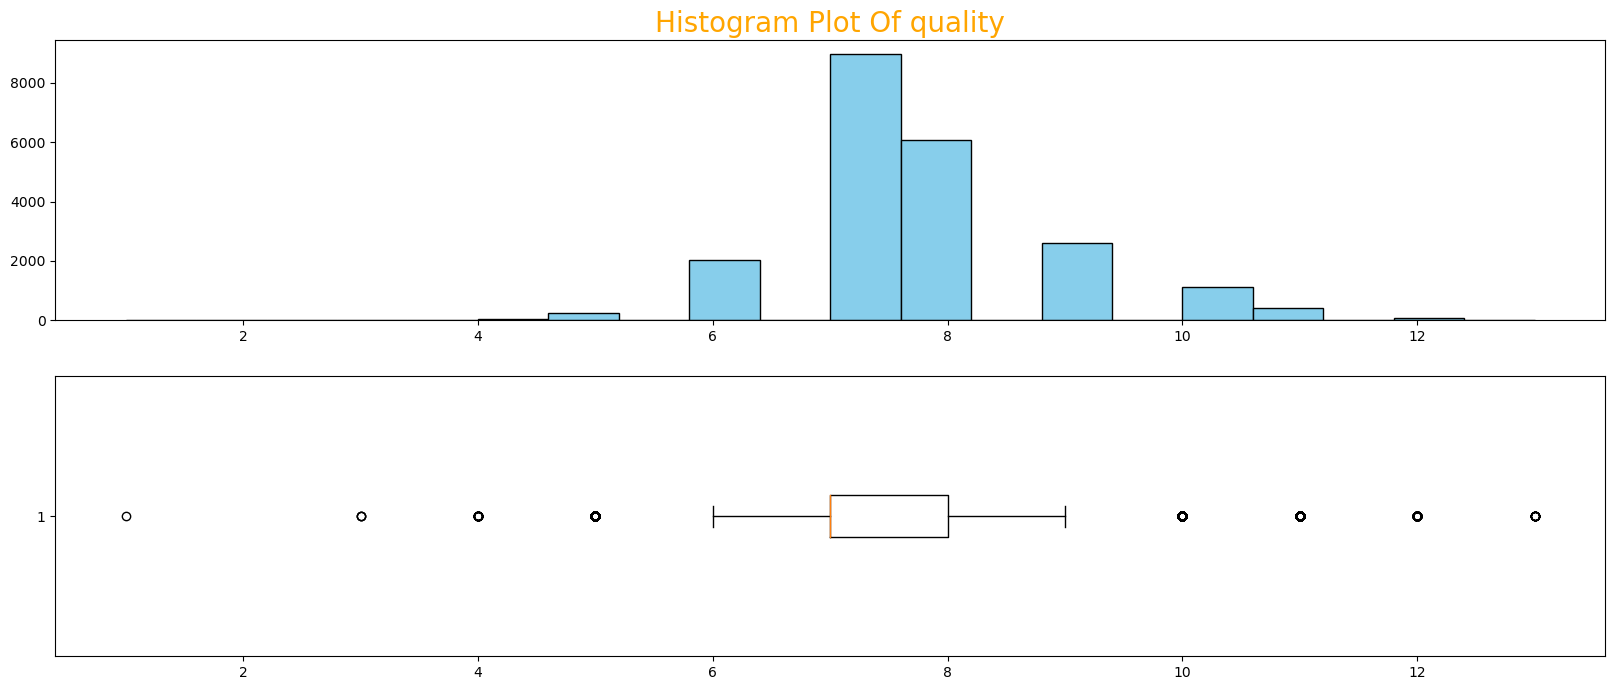

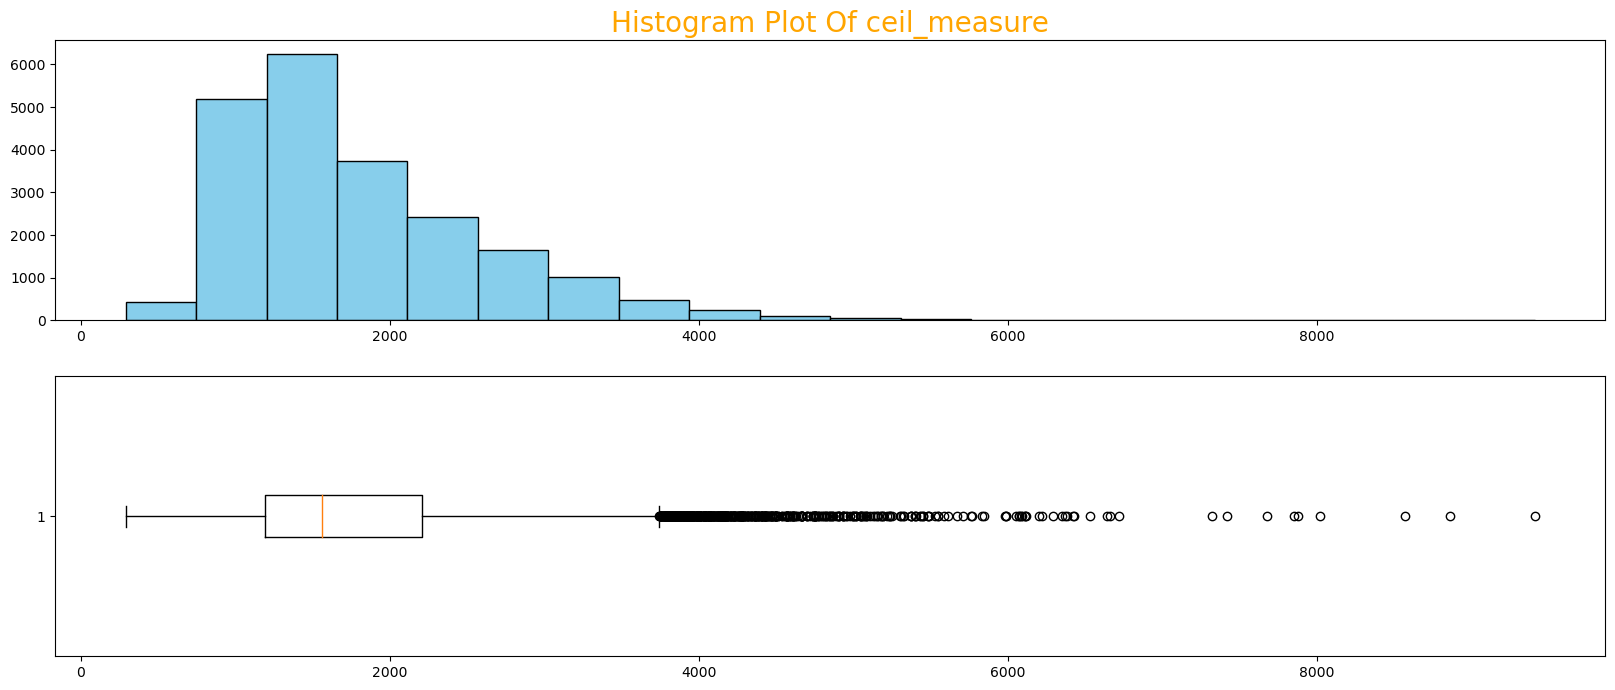

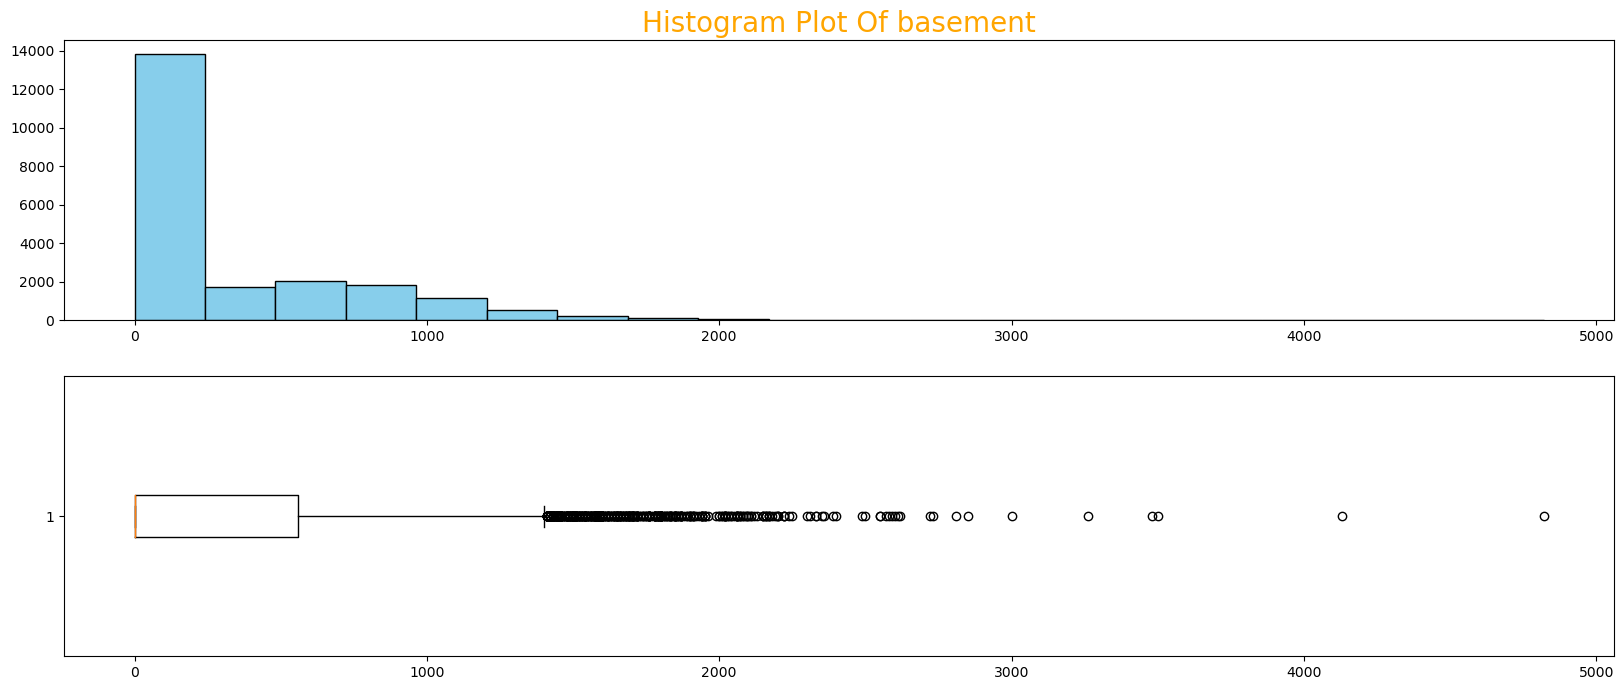

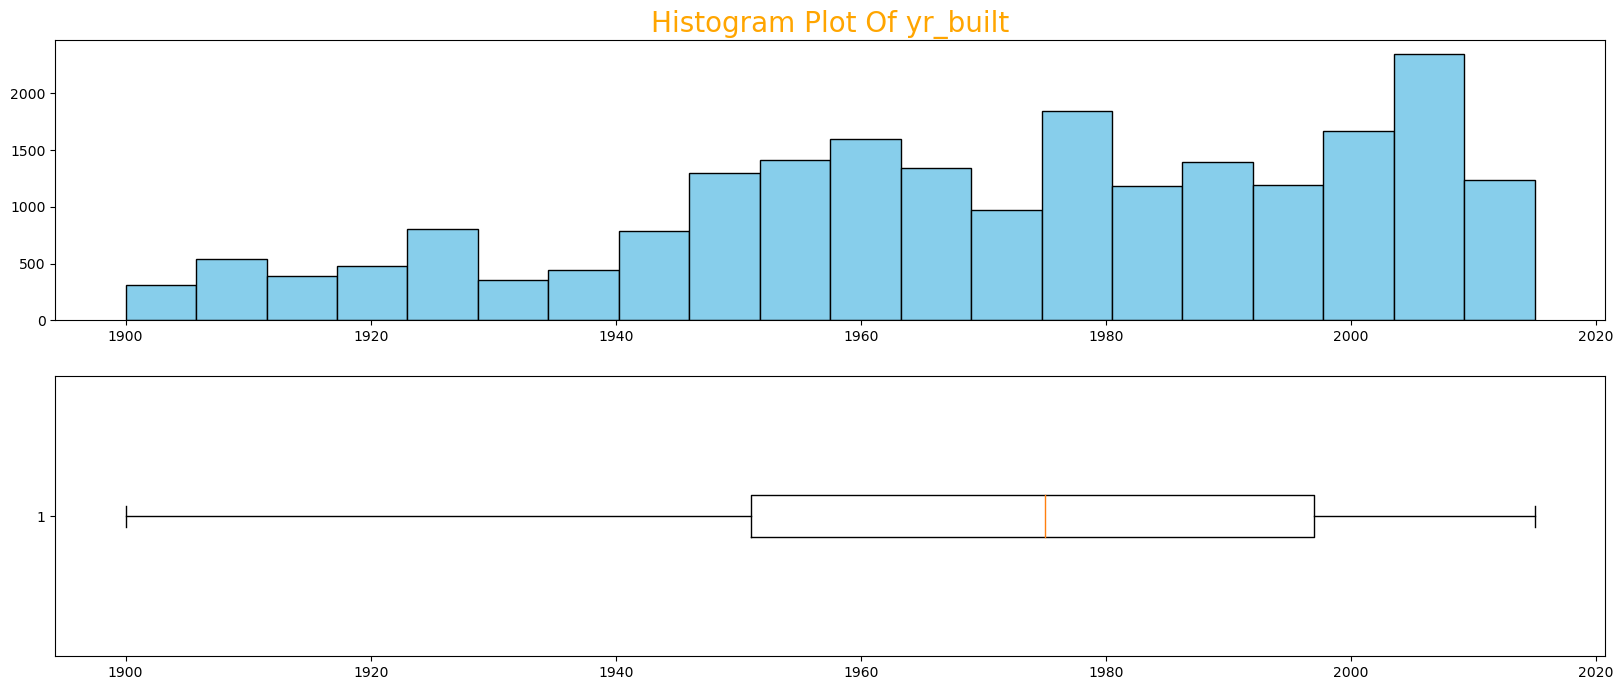

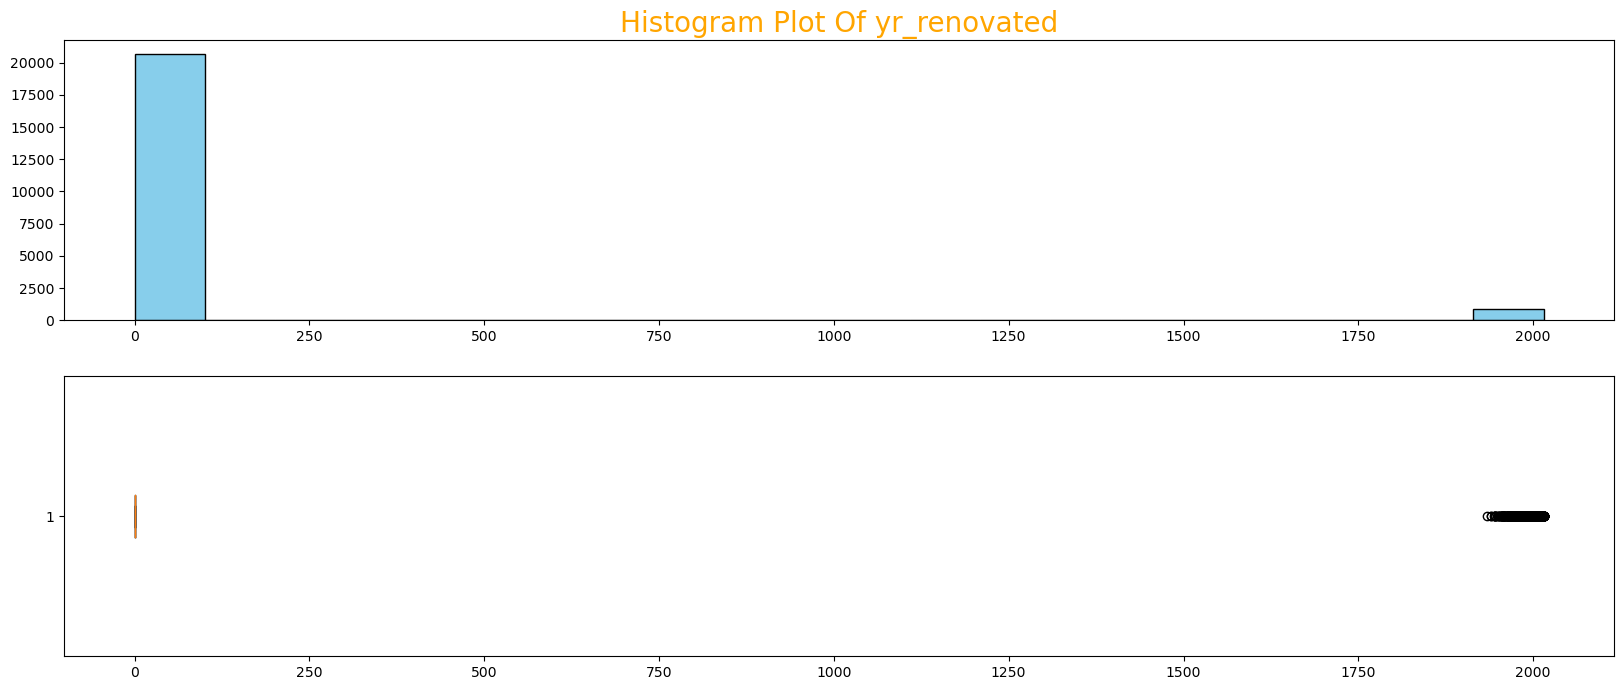

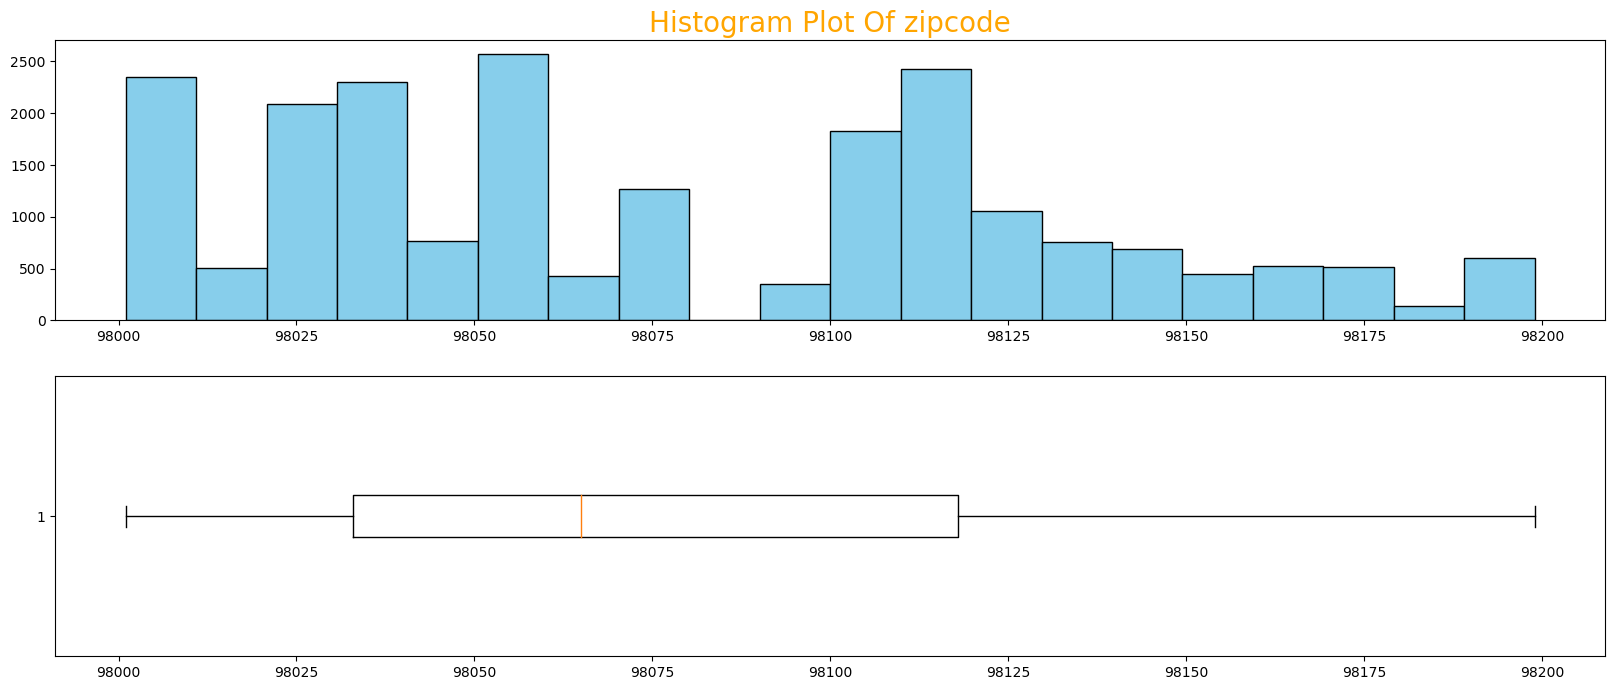

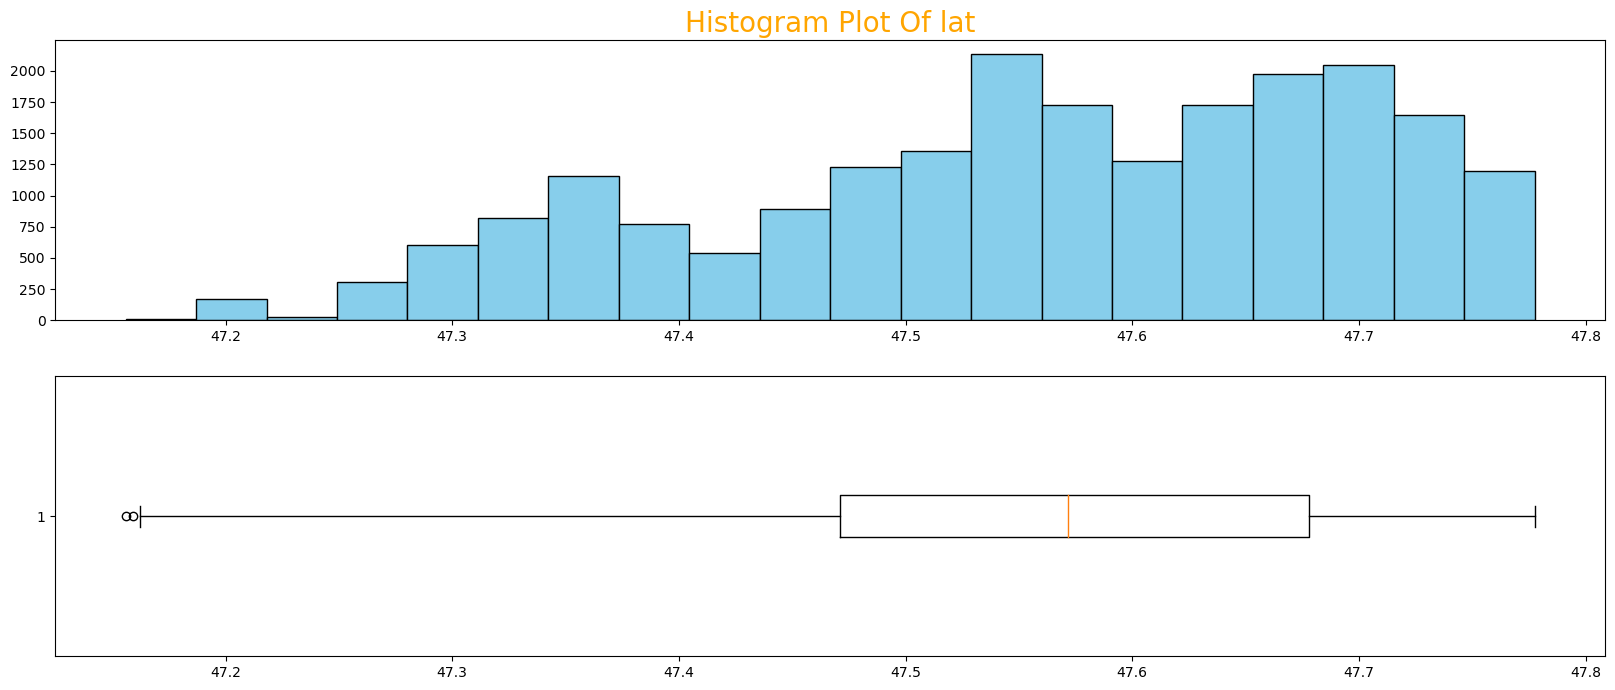

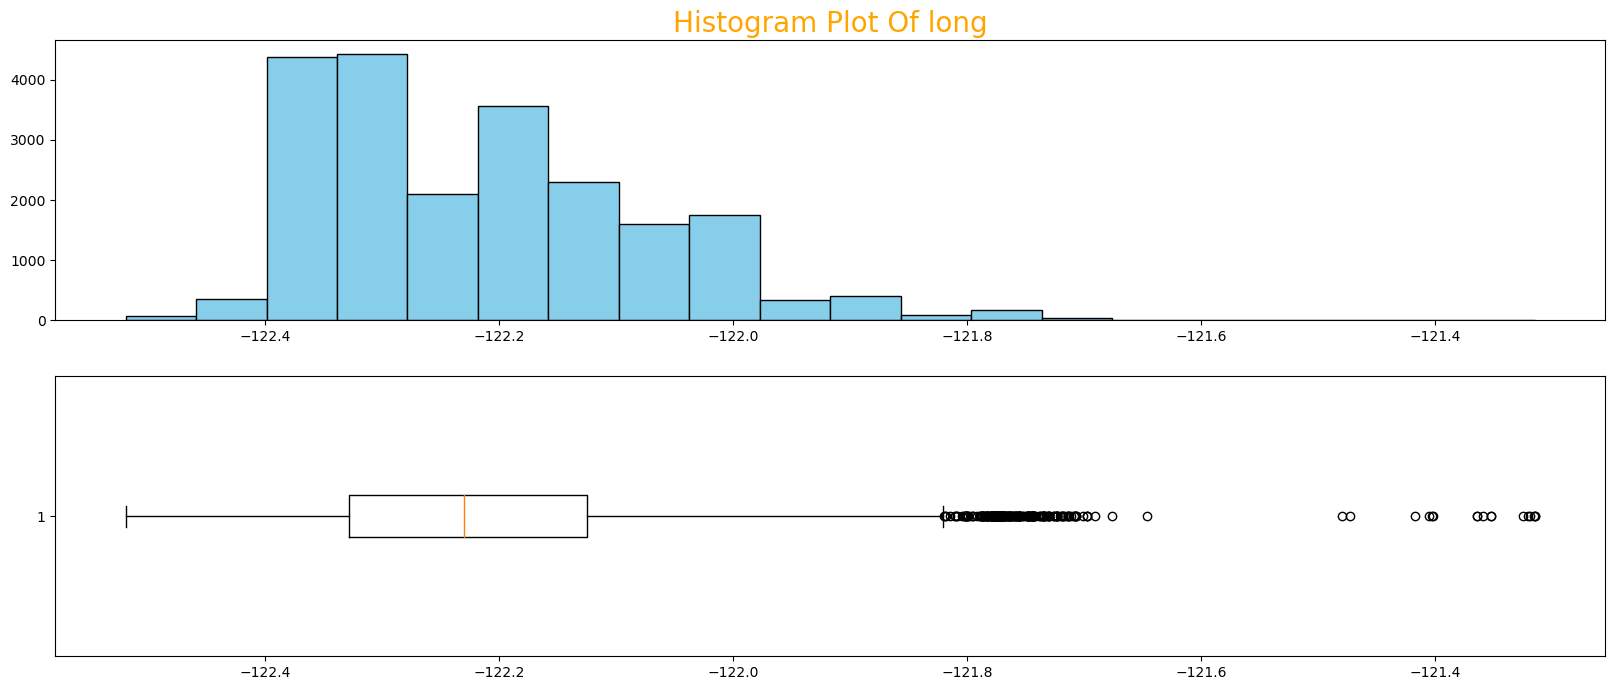

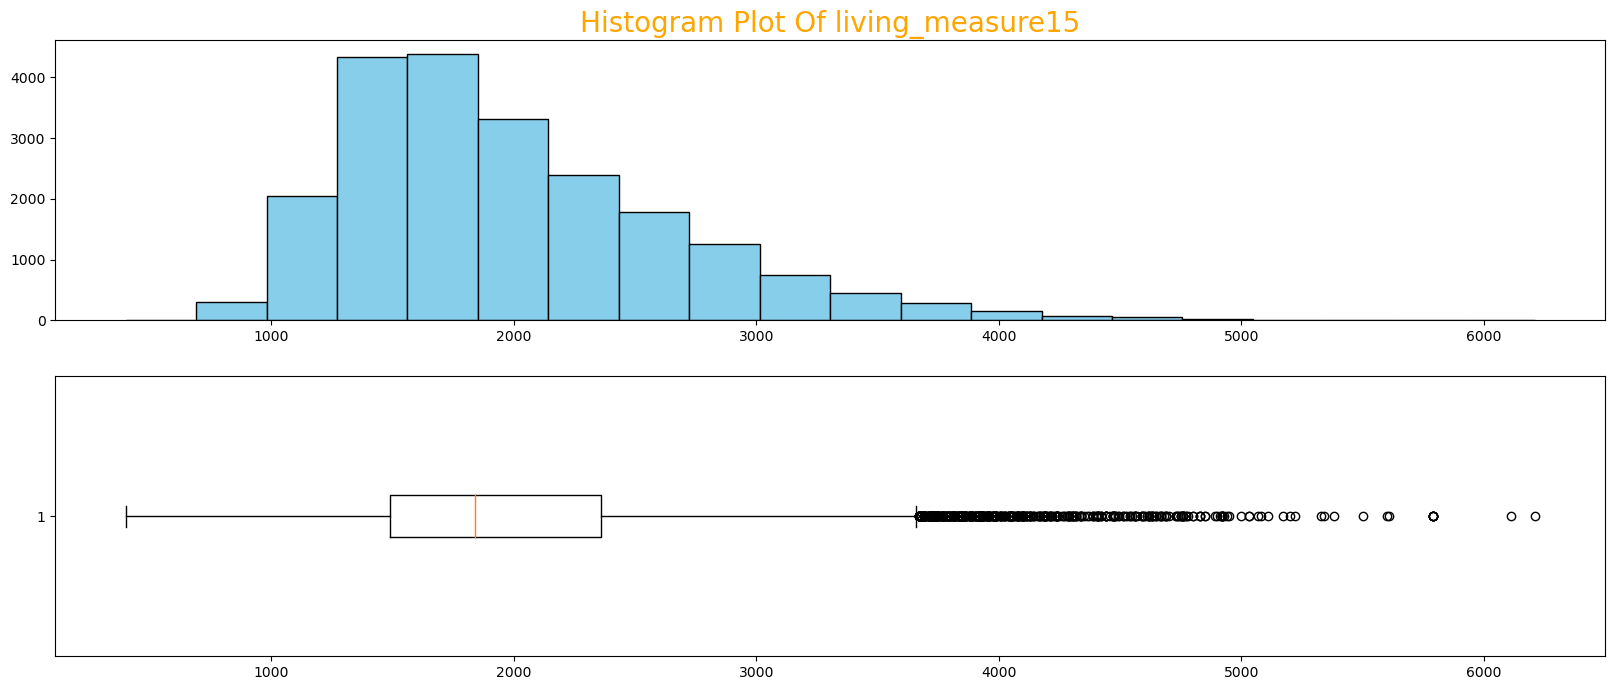

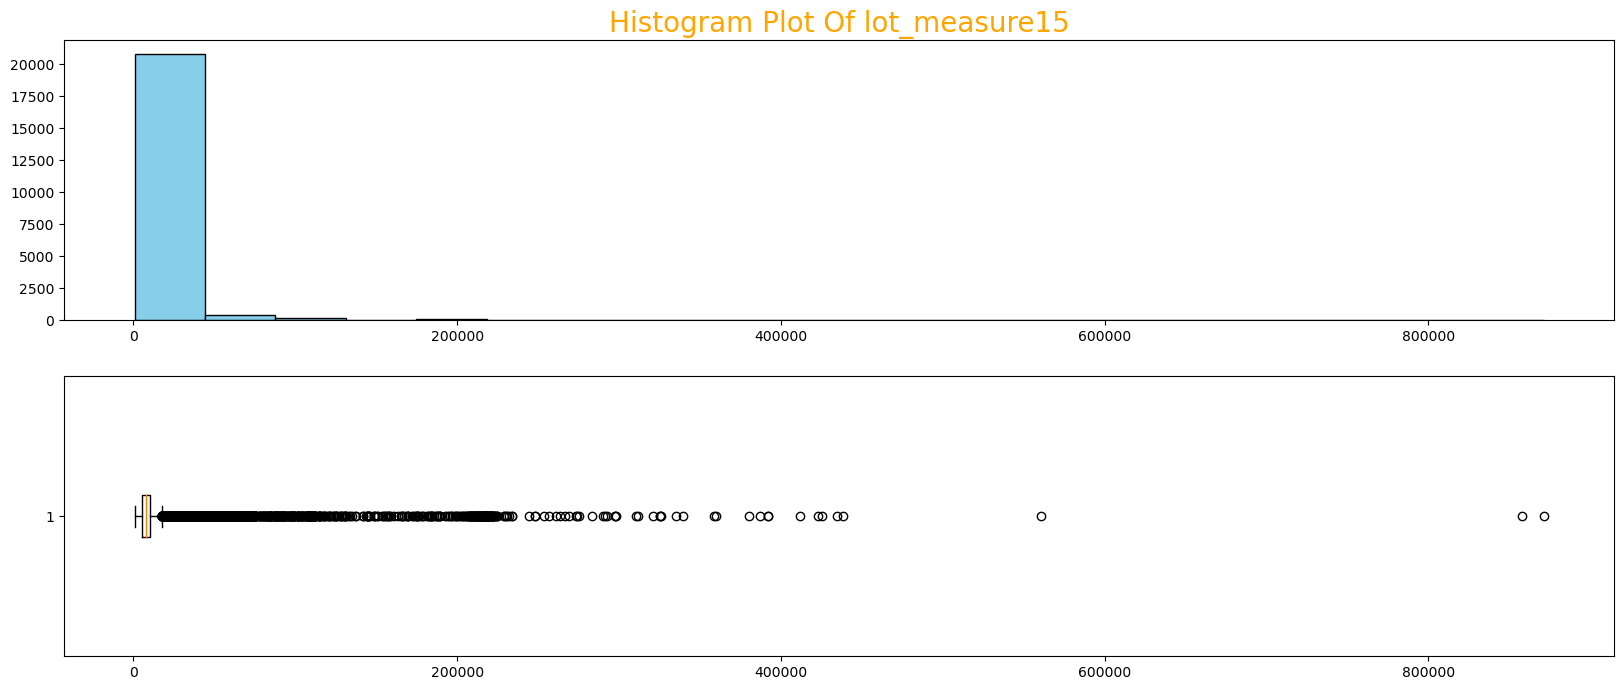

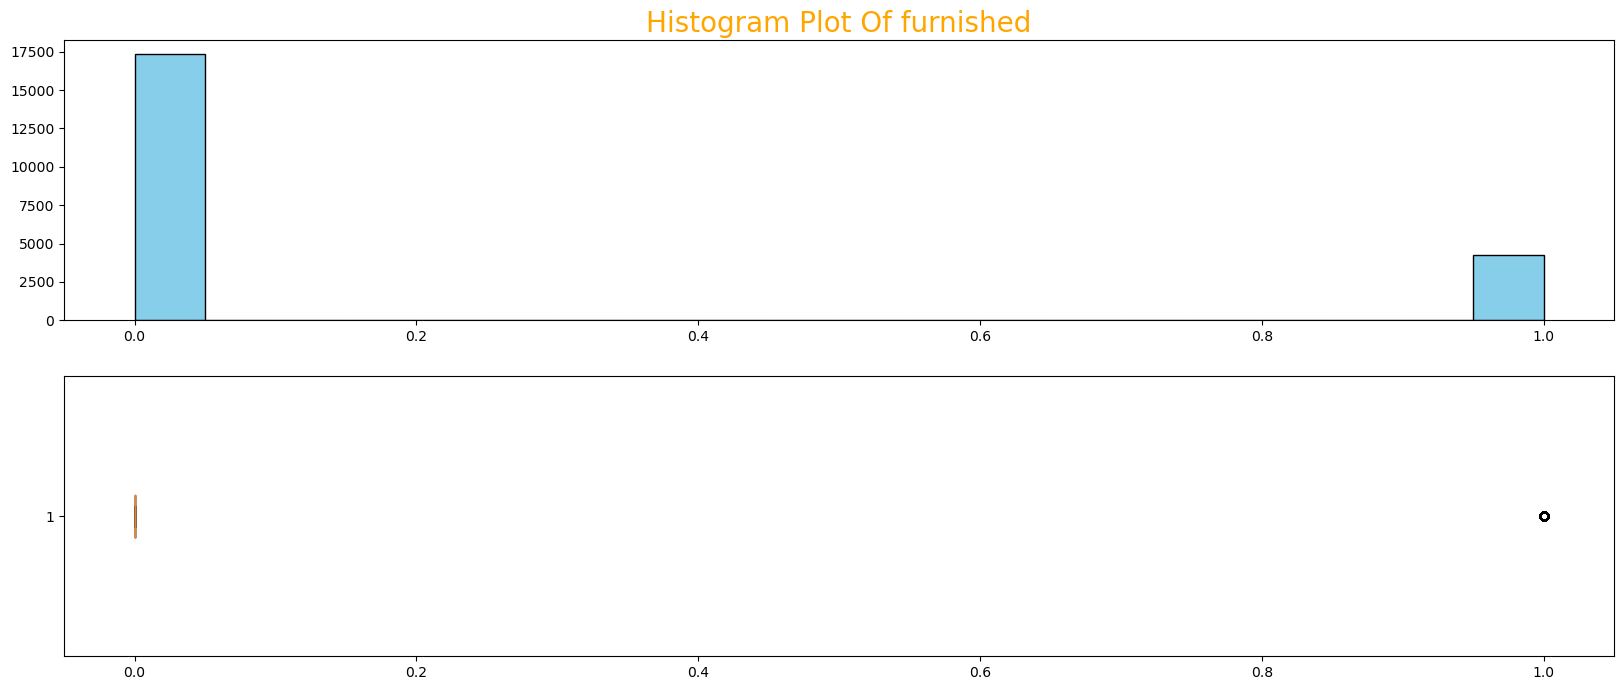

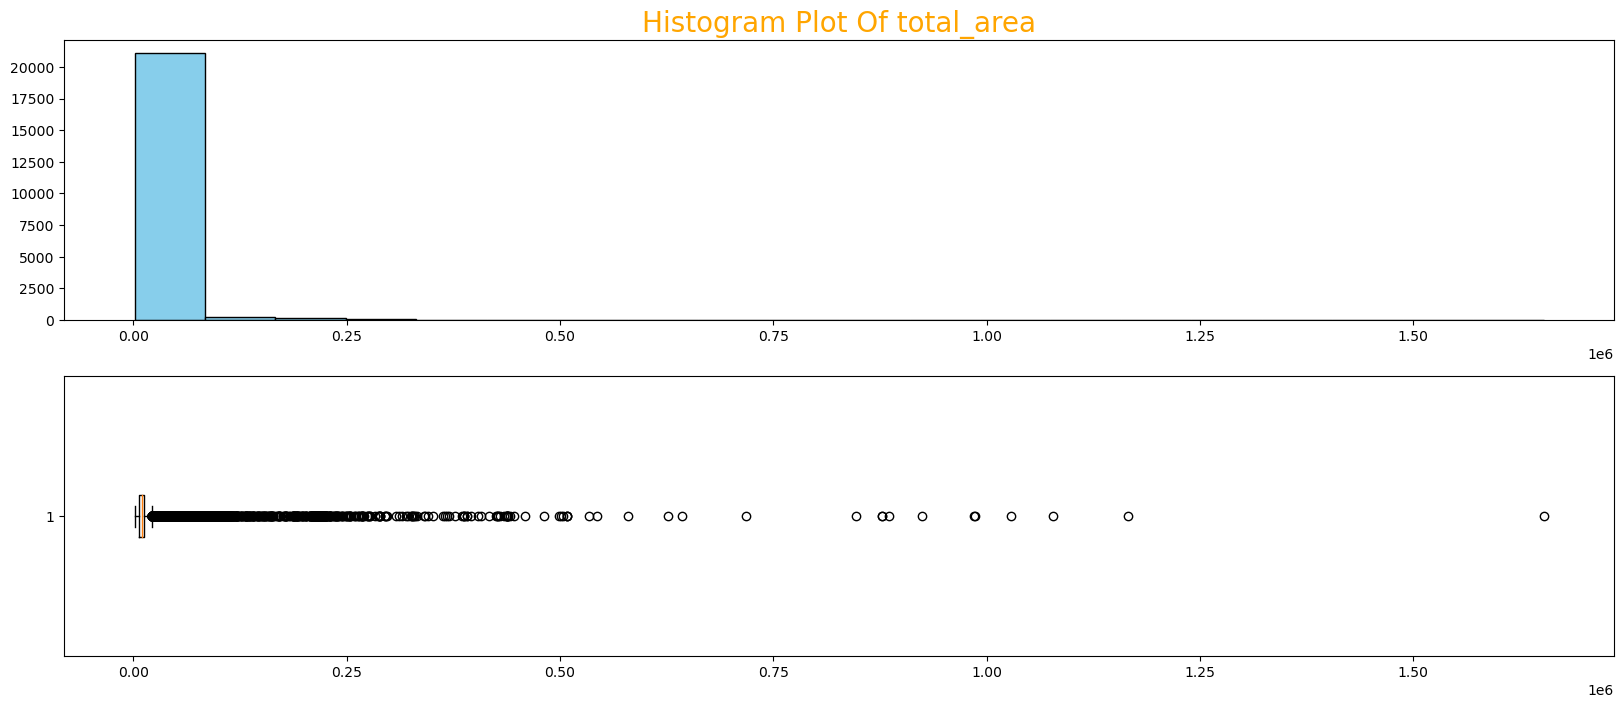

In [115]:
# boxplot all the numerical columns and see if there any outliers
plot_count = 1
fig = plt.figure(figsize=(20,8))
for col in df.iloc[:, 3:].columns:
    fig = plt.figure(figsize=(20,8))
    
    # plot histogram
    plt.subplot(2, 1, plot_count)
    plt.hist(df[col], bins=20, color='skyblue', edgecolor='black')
    plt.title(f"Histogram Plot Of {col}" , fontsize=20, color="orange")
    # plot boxplot

    plt.subplot(2,1,plot_count+1)
    plt.boxplot(df[col], vert=0)
    #plt.title(f"Box Plot Of {col}" , fontsize=20, color="orange") 
    # Display the plot
    #plt.tight_layout()
    plt.show()

In [ ]:
# boxplot all the numerical columns and see if there any outliers
plot_count = 1
fig = plt.figure(figsize=(20,8))
for col in df.iloc[:, 3:].columns:
    # plot boxplot
    fig = plt.figure(figsize=(20,8))
    plt.subplot(1,2,plot_count)
    df.boxplot(column=col)
    plt.title(f"Box Plot Of {col}" , fontsize=20, color="orange")   
    # plot histogram
    plt.subplot(1, 2, plot_count+1)
    plt.hist(df[col], bins=20, color='skyblue', edgecolor='black')
    plt.title(f"Histogram Plot Of {col}" , fontsize=20, color="orange")
    # Display the plot
    #plt.tight_layout()
    plt.show()

# Analysis of dayhours
### Adding a new column for analyzing the data on month and year level

In [117]:
df.dayhours

0        20150427T000000
1        20150317T000000
2        20140820T000000
3        20141010T000000
4        20150218T000000
              ...       
21608    20150310T000000
21609    20140521T000000
21610    20140905T000000
21611    20150206T000000
21612    20141229T000000
Name: dayhours, Length: 21613, dtype: object

In [118]:
# converting the new dataframe for modeling purpose and converting the dayhours into month-year for further analysis

df.dayhours=df.dayhours.str.replace('T000000', "")
df.dayhours=pd.to_datetime(df.dayhours,format='%Y%m%d')
df['month/year']=df['dayhours'].apply(lambda x: x.strftime('%B/%Y'))
df[['dayhours','month/year']]

,dayhours,month/year
0,2015-04-27,April/2015
1,2015-03-17,March/2015
2,2014-08-20,August/2014
3,2014-10-10,October/2014
4,2015-02-18,February/2015
...,...,...
21608,2015-03-10,March/2015
21609,2014-05-21,May/2014
21610,2014-09-05,September/2014
21611,2015-02-06,February/2015


<AxesSubplot:title={'center':'Analysis of DayHours'}, xlabel='month/year', ylabel='count'>

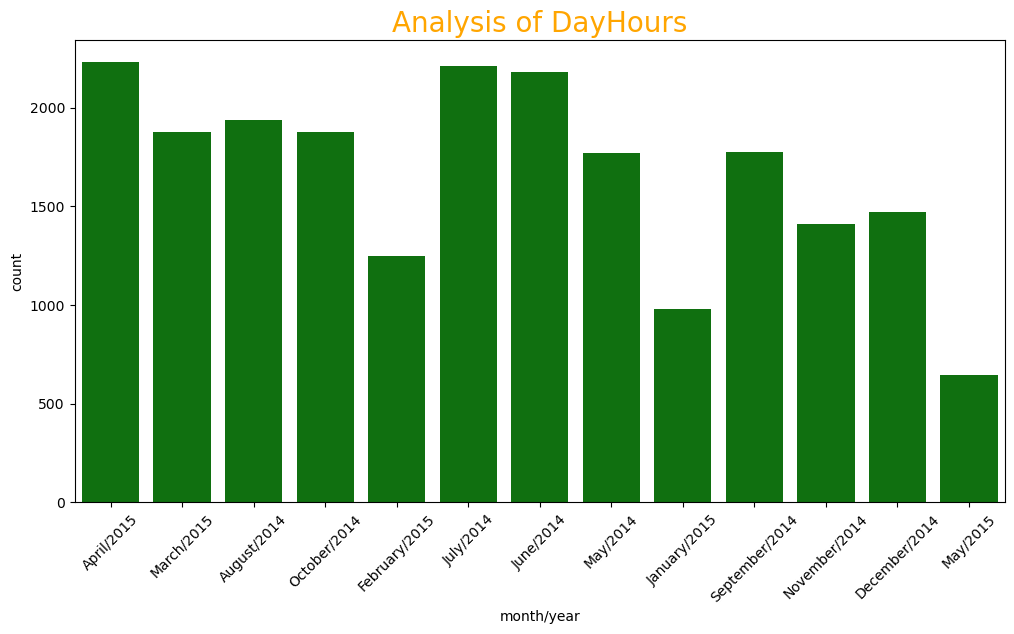

In [119]:
# houses sale per month
plt.figure(figsize=(12,6))
plt.xticks(rotation = 45)
plt.title(f"Analysis of DayHours" , fontsize=20, color="orange")
sns.countplot(df['month/year'],color='green')

* From the above, we can conclude that in april 2015 and june and july of 2014 most houses are sold

In [131]:
df.groupby(['month/year']).size()

month/year
April/2015        2231
August/2014       1940
December/2014     1471
February/2015     1250
January/2015       978
July/2014         2211
June/2014         2180
March/2015        1875
May/2014          1768
May/2015           646
November/2014     1411
October/2014      1878
September/2014    1774
dtype: int64